In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Compare

## Leave last item out of subset of users

In [2]:
def leave_users_out(full_data, leave_out, seed=1234):
    np.random.seed(seed)
    full_data['index'] = full_data.index
    user_index_df = full_data.groupby('user')['index'].apply(list)
    users = np.random.choice(list(user_index_df.index), leave_out, replace=False)
    users_indices = []
    
    for user in users:
        users_indices.extend(user_index_df.loc[user])
    
    sub_set = full_data.loc[users_indices]
    remaining = full_data.drop(users_indices)
    
    return remaining.drop(columns=['index']), sub_set.drop(columns=['index'])

In [3]:
def leave_last_x_out(full_data, n_users, leave_out=1, seed=1234):
    # Input: data must contain user_id
    # Output: full_data = without all last (time order) entries in leave one out set
    #         leave_one_out_set = data with one user and one item from full_data
    np.random.seed(seed)
    
    full_data['index'] = full_data.index
    user_items_ind = full_data.groupby('user_id')['index'].apply(list)
    users = full_data.user_id.unique()
    leave_out_indices = []
    users_picked = []
    
    for i in range(len(full_data.user_id.unique())):
        random_user = np.random.choice(users)
        item_indices = user_items_ind[random_user] # random user's items indices
        if random_user in users_picked or len(item_indices) <= leave_out:
            random_user = np.random.choice(users)
            item_indices = user_items_ind[random_user] # random user's items indices
        else:
            users_picked.append(random_user)
            leave_out_indices.extend(item_indices[-leave_out:])
        
        if len(users_picked) == n_users:
            break
        
    if len(users_picked) < n_users:
        error = 'Cannot pick ' + str(n_users) + ' users with more than ' + str(leave_out) + ' items'
        solution = '\nTry a smaller test and/or validation percentage of the data'
        raise ValueError(error + solution) 
            
    leave_out_set = full_data.loc[leave_out_indices] # the last items of n_users users with n_item > leave_out
    full_data_leave_one_out = full_data.drop(leave_out_indices) # drops last items for n_users users
    
    return full_data_leave_one_out.drop(columns=['index']), leave_out_set.drop(columns=['index'])

In [4]:
def train_val_test_split(df, batch_size, val_perc, test_perc, n_items_val, n_items_test, stats=True):
    # Input: df with user and item id, batch size for CFRNN data, val and test perc of users
    #        number of last items to leave out for val and test set
    # Output:full_data = total users and items of the original df, 
    #        Train, validation and test sets
    
    total_users = len(df.user_id.unique()) # Need all users for BPR
    total_items = len(df.item_id.unique()) # Need all items for CFRNN
    
    users_to_remove = len(df.user_id.unique())%batch_size #Batch size compatible for CFRNN
    df_new, deleted_users = leave_users_out(df, users_to_remove)

    test_users = int(test_perc*total_users / 64 + 1) * 64 # Number of users to be used for testing
    test_last_items = n_items_test # Items to be removed from test users in train set and used in test set

    val_users = int(val_perc*total_users / 64 + 1) * 64
    val_last_items = n_items_val
    
    train_set, test_set = leave_last_x_out(df_new, test_users, test_last_items)
    train_set, val_set = leave_last_x_out(train_set, val_users, val_last_items)
    
    if stats:
        print('Total number of items:', total_items)
        print('Total users:', total_users)
        print('Number of train users:', len(train_set.user_id.unique()))
        print('Number of test users:', test_users)
        print('Number of validation users:', val_users, '\n')
        print('Users deleted:', len(deleted_users.user_id.unique()))
    
    return total_users, total_items, train_set, val_set, test_set

In [12]:
def print_stats(df):
    user_ratings = df.groupby('user')['rating'].count()
    item_ratings = df.groupby('item')['rating'].count()
    norpu = user_ratings.mean()
    norpi = item_ratings.mean()
    total_users = df.user.unique().size
    total_items = df.item.unique().size
    sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))
    
    BATCH_SIZE = 64
    val_perc = test_perc = 0.1
    n_last_items_val = n_last_items_test = 1
    total_users, total_items, train_set, val_set, test_set = \
    train_val_test_split(df, BATCH_SIZE, val_perc, test_perc, n_last_items_val, n_last_items_test)
    
    print('rows ', len(df), 
          '\n#ratings/user', round(norpu,2), 
          '\n#ratings/item', round(norpi,2), 
          '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), 
          '\n#users ', df['user'].unique().size, 
          '\n#items ', df['item'].unique().size, 
          '\nsparse ', round(sparseness,5))

In [13]:
def show_results(metrics, file_name, plot_title, legend_names, store=False, path=''):
    ranks_at = metrics[0]['rank_at']
    
    figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
    figure.suptitle(plot_title)
    figure.subplots_adjust(wspace=0.4, hspace=0.4)
        
    bar_width = 1.0
    bar_dist = 1.0
    line_width = 2
    title_size = 'large'
    
    #Plots
    for i, m in enumerate(metrics):
        axes[0,0].plot(ranks_at, m['recall'], linewidth=line_width)
        axes[0,1].plot(ranks_at, m['precision'], linewidth=line_width)
        axes[1,0].bar(ranks_at[1:] + i*bar_dist, m['hitcounts'][1:], width=bar_width, align='center')
        axes[1,1].bar(ranks_at[0] + i*bar_dist, m['hitcounts'][0], width=bar_width, align='center')

    # Decoration
    ## Recall@1-20    
    for i, rank in enumerate(ranks_at):
        top = max([m['recall'][i] for m in metrics])
        axes[0,0].vlines(rank, 0, top, linestyle = '--', color='gainsboro', linewidth=line_width/2) 
    axes[0,0].set_title('Recall@1-20', fontsize=title_size)
    axes[0,0].set_xlabel('Rank@')
    axes[0,0].set_ylabel('Recall')
    
    ## Precision@1-20    
    for i, rank in enumerate(ranks_at):
        top = max([m['precision'][i] for m in metrics])
        axes[0,1].vlines(rank, 0, top, linestyle = '--', color='gainsboro', linewidth=line_width/2) 
    axes[0,1].set_title('Precision@1-20', fontsize=title_size)
    axes[0,1].set_xlabel('Rank@')
    axes[0,1].set_ylabel('Precision')
     
    ## Hitcounts@5-20
    axes[1,0].set_title('Hitcounts@5-20', fontsize=title_size)
    axes[1,0].set_xlabel('Rank@')
    axes[1,0].set_ylabel('Hitcounts')
    axes[1,0].set_xlim([1,24])
    axes[1,0].set_xticks(ranks_at[1:])
    
    ## Hitcounts@1
    axes[1,1].set_title('Hitcounts@1', fontsize=title_size)
    axes[1,1].set_xlabel('Rank@1')
    axes[1,1].set_ylabel('Hitcounts')
    axes[1,1].set_xticks([])
    
    figure.legend(legend_names, loc='lower center', ncol=4, fontsize='large')
    
    if store:
        figure.savefig(path + file_name + '_results')
    plt.show()

## Init

In [14]:
path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
names_am = ['Amazon_01_users']
names_ml = ['ML_01_users']

res_path = path + 'Results/Results_17_04/'
store_path = path + 'Plots/CFRNN_plots/'
file_names = names_am + names_ml
data_paths = ['Data/Amazon/']*len(names_am) + ['Data/ML/']*len(names_ml)

In [15]:
legend_names = ['BPR', 'Random', 'Popularity']

## Plot 

In [ ]:
store_path = path + 'Results/Results_17_04/'

Total number of items: 247465
Total users: 121372
Number of train users: 121344
Number of test users: 12160
Number of validation users: 12160 

Users deleted: 28
rows  1058788 
#ratings/user 8.72 
#ratings/item 4.28 
average rating 4.28 
#users  121372 
#items  247465 
sparse  0.99996 
Train users: 121344 
Val users: 12160 
Test users: 12160


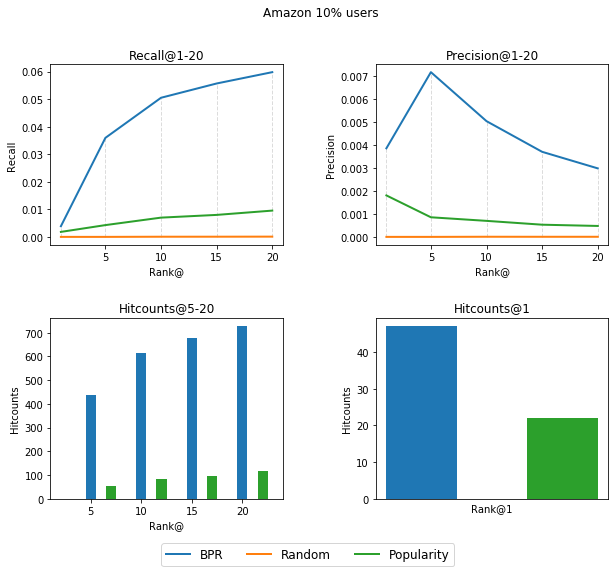

In [9]:
df = pd.read_pickle(path + 'data/Amazon/' + names_am[0])
print_stats(df)
file_name = 'Amazon_01_user'

#     cfrnn = pd.read_pickle(res_path + 'CFRNN/metrics_CFRNN_' + file_name) 
bpr = pd.read_pickle(res_path + 'metrics_bpr_Amazon_01_users')
rand = pd.read_pickle(res_path + 'rand_bench_Amazon_01_users')
pop = pd.read_pickle(res_path + 'pop_bench_Amazon_01_users')

all_metrics = [bpr, rand, pop]

show_results(all_metrics, file_name, 'Amazon 10% users', legend_names, store=True, path=store_path)

Total number of items: 27387
Total users: 16254
Number of train users: 16192
Number of test users: 1664
Number of validation users: 1664 

Users deleted: 62
rows  2446037 
#ratings/user 150.49 
#ratings/item 89.31 
average rating 3.55 
#users  16254 
#items  27387 
sparse  0.99451 
Train users: 16192 
Val users: 1664 
Test users: 1664


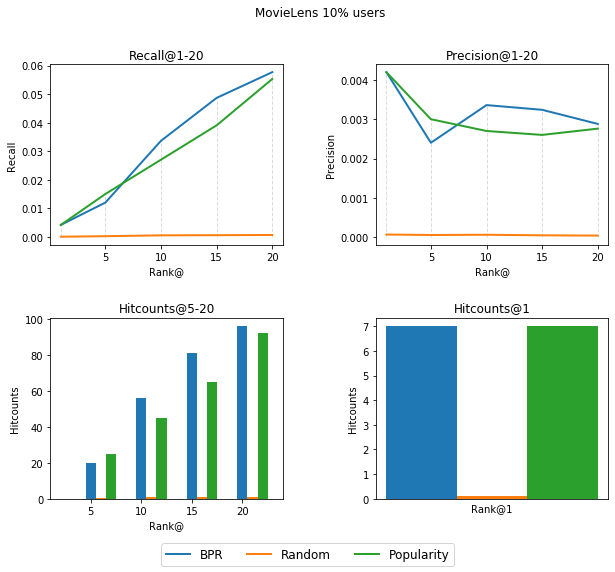

In [10]:
df = pd.read_pickle(path + 'data/ML/' + names_ml[0])
print_stats(df)
file_name = 'ML_01_user'

#     cfrnn = pd.read_pickle(res_path + 'CFRNN/metrics_CFRNN_' + file_name) 
bpr = pd.read_pickle(res_path + 'metrics_bpr_ML_01_users')
rand = pd.read_pickle(res_path + 'rand_bench_ML_01_users')
pop = pd.read_pickle(res_path + 'pop_bench_ML_01_users')

all_metrics = [bpr, rand, pop]

show_results(all_metrics, file_name, 'MovieLens 10% users', legend_names, store=True, path=store_path)

Total number of items: 27387
Total users: 16254
Number of train users: 16192
Number of test users: 1664
Number of validation users: 1664 

Users deleted: 62
rows  2446037 
#ratings/user 150.49 
#ratings/item 89.31 
average rating 3.55 
#users  16254 
#items  27387 
sparse  0.99451 
Train users: 16192 
Val users: 1664 
Test users: 1664


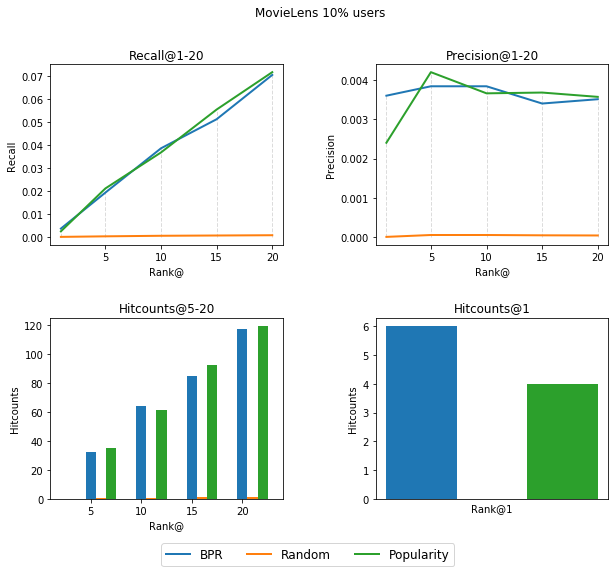

In [11]:
df = pd.read_pickle(path + 'data/ML/' + names_ml[0])
print_stats(df)
file_name = 'ML_01_user'

#     cfrnn = pd.read_pickle(res_path + 'CFRNN/metrics_CFRNN_' + file_name) 
bpr = pd.read_pickle(res_path + 'metrics_bpr_ML_01_rate_above_3')
rand = pd.read_pickle(res_path + 'rand_bench_ML_01_users_rate_above_3')
pop = pd.read_pickle(res_path + 'pop_bench_ML_01_users_rate_above_3')

all_metrics = [bpr, rand, pop]

show_results(all_metrics, file_name, 'MovieLens 10% users', legend_names, store=False, path=store_path)

In [26]:
plot_titles = ['Amazon Fasion 10%', 'MovieLens 10%']

for data_path, file_name, plot_title in zip(data_paths, file_names, plot_titles):
    print('='*100)
    print(file_name)
    df = pd.read_pickle(path + data_path + file_name)
    print_stats(df)
    
#     cfrnn = pd.read_pickle(res_path + 'CFRNN/metrics_CFRNN_' + file_name) 
    bpr = pd.read_pickle(res_path + '/metrics_bpr_' + file_name)
    rand = pd.read_pickle(res_path + 'Benchmarks/rand_bench_' + file_name)
    pop = pd.read_pickle(res_path + 'Benchmarks/pop_bench_' + file_name)

    all_metrics = [cfrnn, bpr, rand, pop]
    
    show_results(all_metrics, file_name, plot_title, legend_names, store=True, path=store_path)
    print('='*100)
    print('\n','\n')

bpr_amazon_01


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/Data/Amazon/bpr_amazon_01'

# Full data stats

In [144]:
path

'/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

In [147]:
df_amazon = pd.read_pickle(path + '/Data/Amazon/Amazon_full')

In [148]:
df_ml = pd.read_pickle(path + '/Data/ML/ML_full')

In [152]:
print_stats(df_amazon)

rows  10592657 
#ratings/user 8.73 
#ratings/item 28.22 
average rating 4.28 
#users  1213729 
#items  375397 
sparse  0.99998


In [153]:
print_stats(df_ml)

rows  25000095 
#ratings/user 153.81 
#ratings/item 423.39 
average rating 3.53 
#users  162541 
#items  59047 
sparse  0.9974
